# DIVAnd full analysis

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
2. Data download from other sources and duplicate removal.
3. Quality control.
4. Parameter optimisation.
5. Spatio-temporal interpolation with `DIVAnd`.

In [31]:
using divand
using PyPlot
using NCDatasets
using PhysOcean
using DataStructures

# Load a more efficient version of sparse matrix multiplication
include(joinpath(Pkg.dir("divand"),"src","override_ssmult.jl"))

In [15]:
dx, dy = 0.25, 0.25
lonr = 11.5:dx:20
latr = 39:dy:46
timerange = [Date(1950,1,1),Date(2017,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = [0.,20.,50.];

3-element Array{Float64,1}:
  0.0
 20.0
 50.0

## 1. Read your ODV file
Adapt the `datadir` and `datafile` values.

In [6]:
datadir = "./Adriatic/"
datafile = joinpath(datadir, "AdriaticSea_SDC.txt")
if isfile(datafile)
    info("File exists")
else
    warn("File does not exist")
end

INFO: File exists


In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = ODVspreadsheet.load(Float64,[datafile],
                           ["Water body salinity"]; nametype = :localname );

INFO: No. of profiles in the file: 34709


In [11]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (12.25017, 20.11)
              minimum and maximum of obs. dimension 2: (39.55676, 45.755)
              minimum and maximum of obs. dimension 3: (0.0, 1484.203)
              minimum and maximum of obs. dimension 4: (1911-08-17T09:24:00, 2015-02-10T10:43:00)
                          minimum and maximum of data: (4.07, 40.880001)


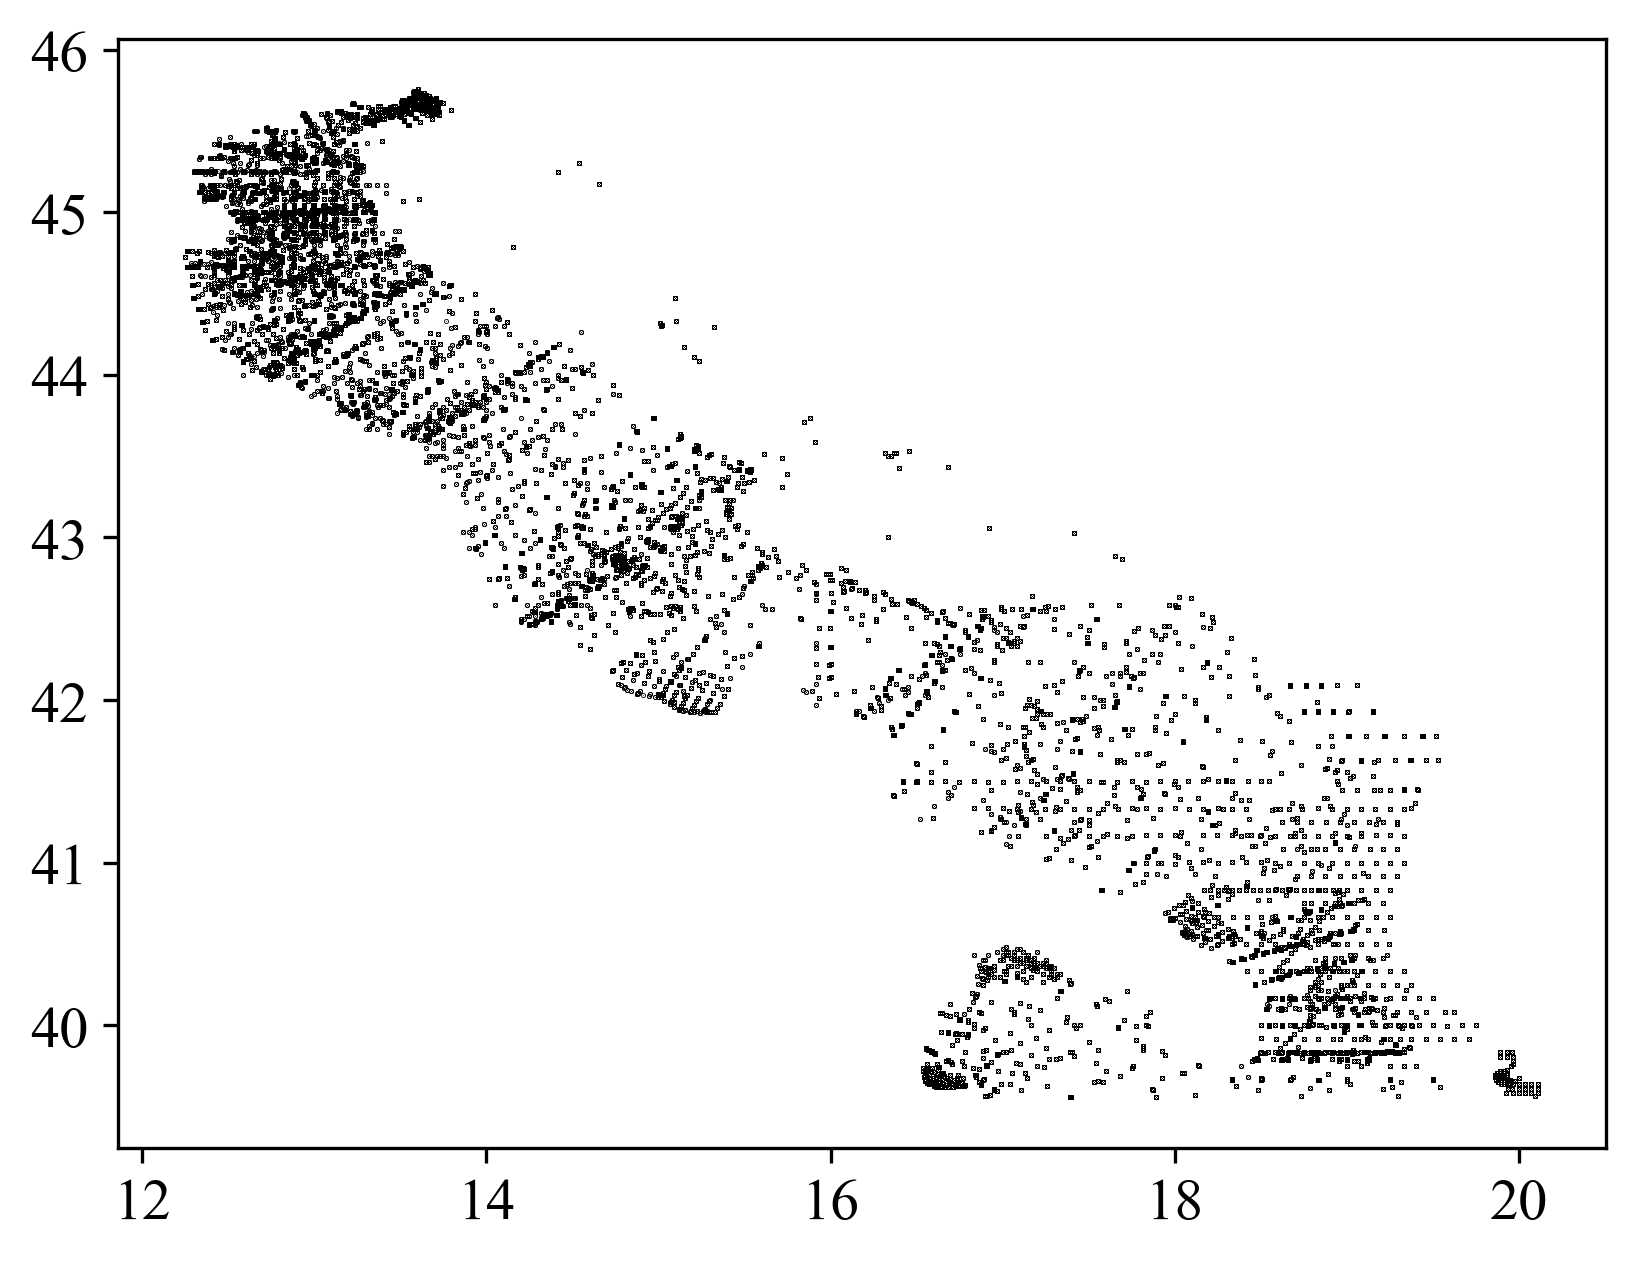

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7faa92b49110>

In [5]:
figure()
plot(obslon, obslat, "ko", markersize=.2)

## 2. Extract the bathymetry
### 2.1 Choice of bathymetry
Modify `bathname`

In [13]:
bathname = "gebco_30sec_8.nc"
if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end
bx,by,b = extract_bath(bathname,true,lonr,latr);

INFO: Bathymetry file already downloaded


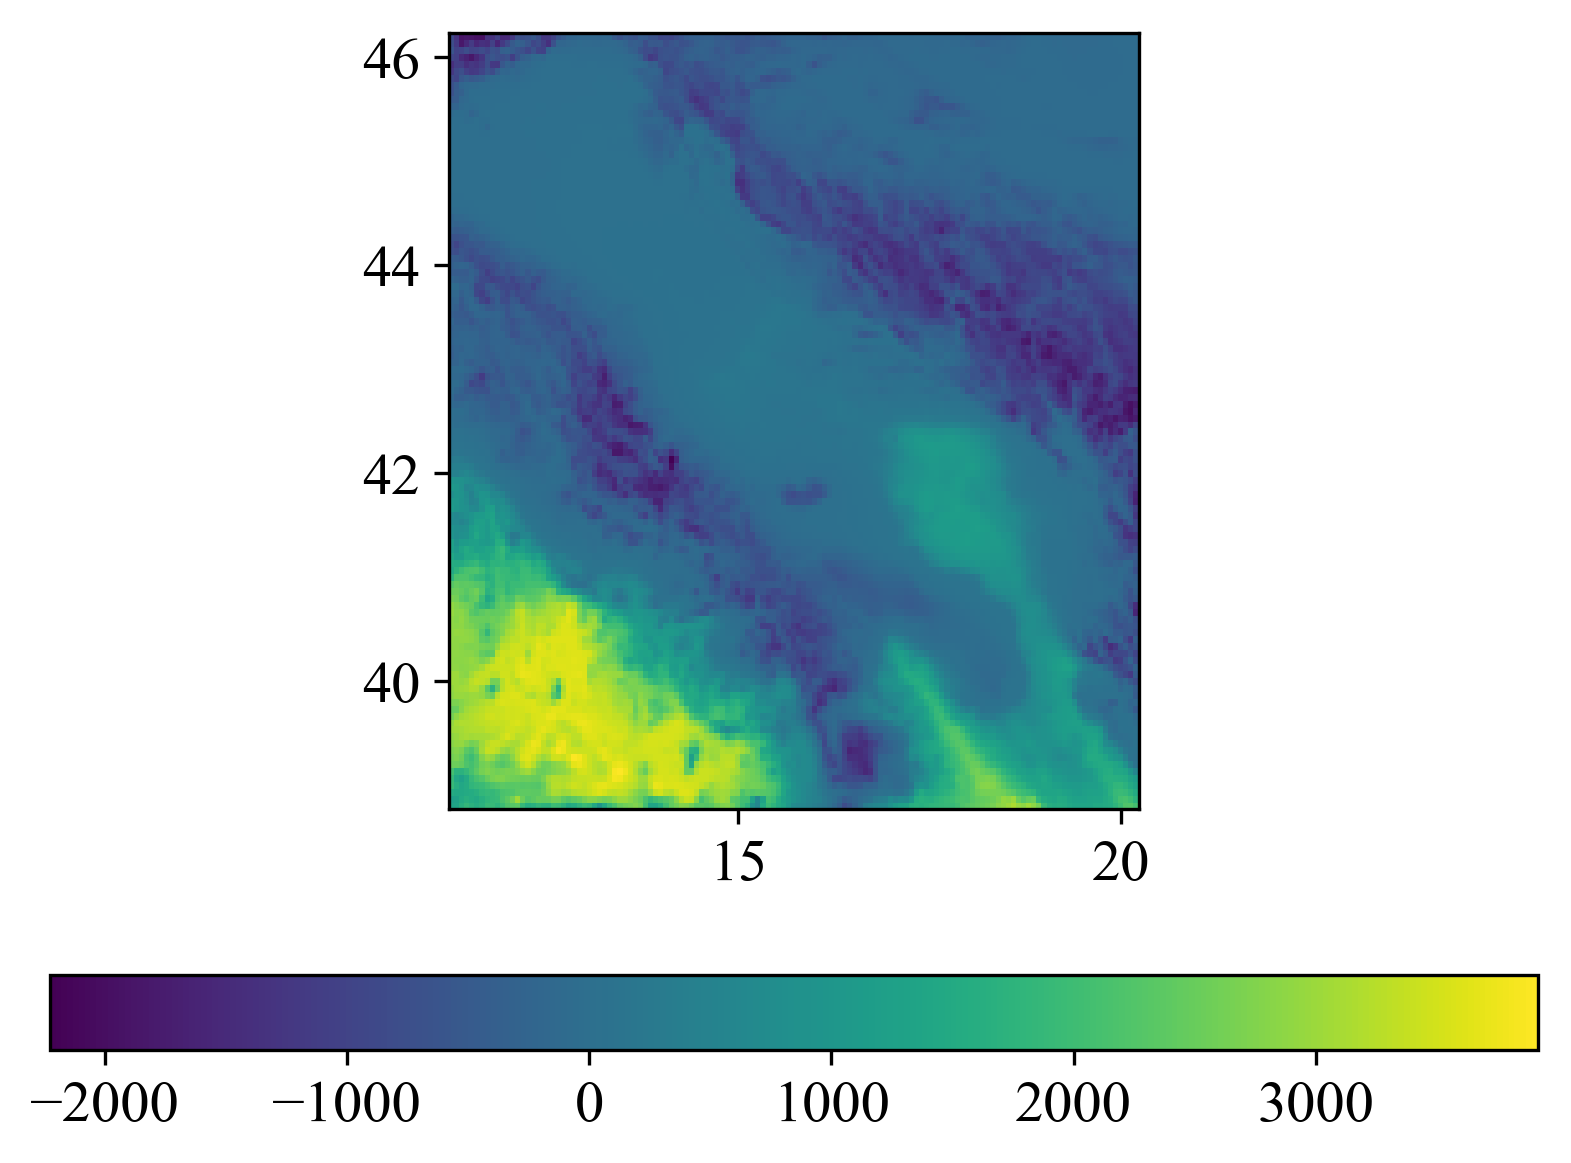

In [14]:
pcolor(bx,by,b'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

### 2.2 Create mask

In [16]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end

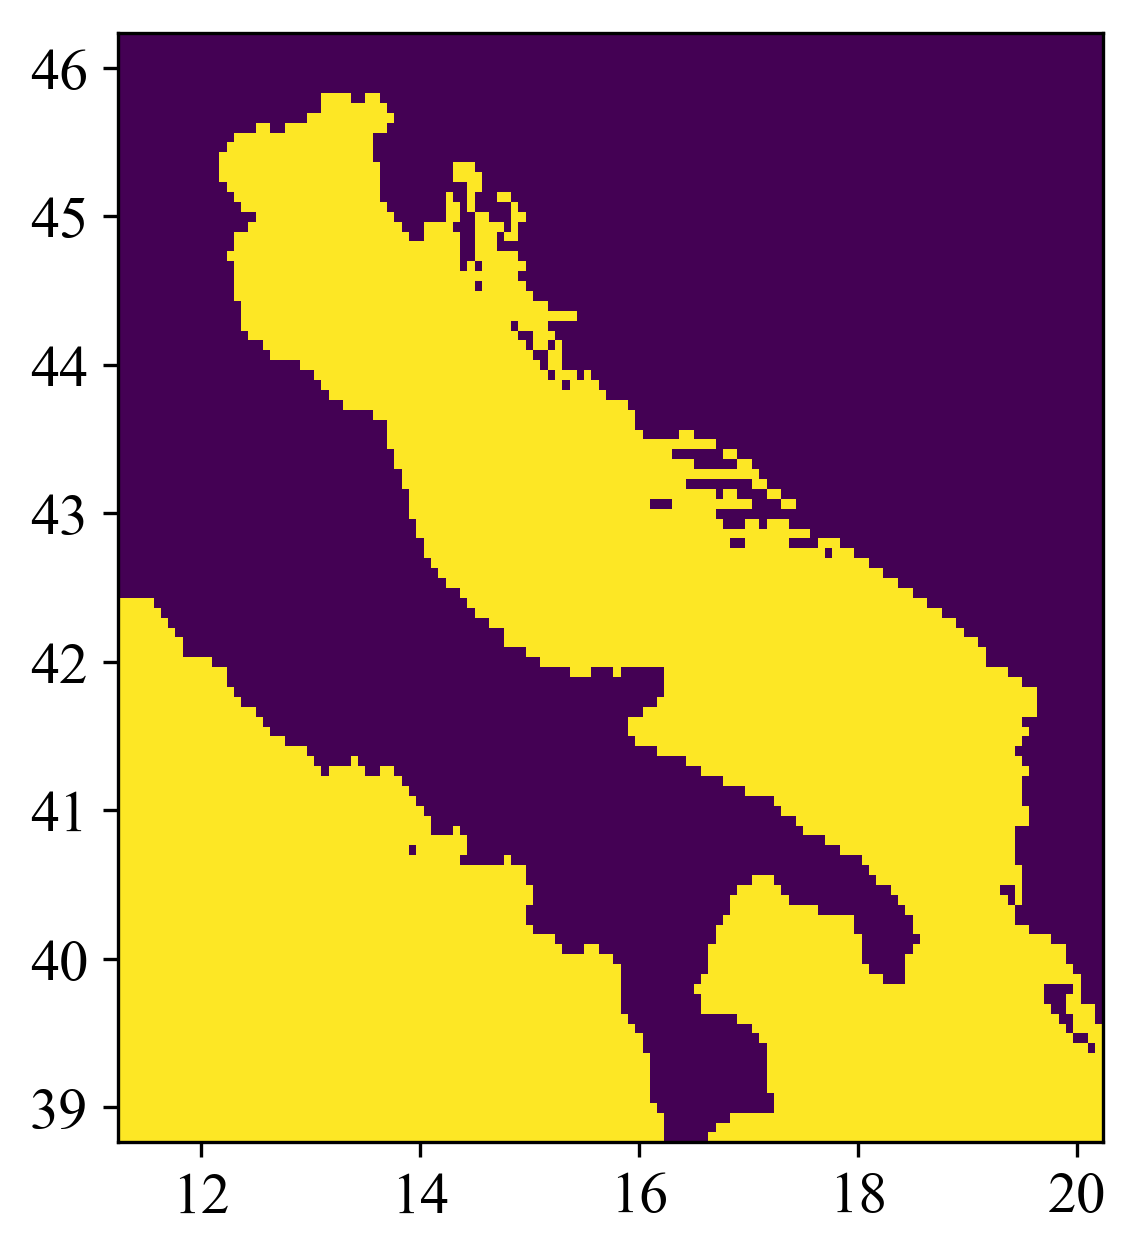

In [32]:
pcolor(bx,by,Float64.(mask[:,:,1])'); 
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

### 2.3 Edit the mask
As an example we will remove the Mediterranean Sea from the domain.

In [ ]:
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

In [56]:
mask_edit = copy(mask);
sel_mask1 = (grid_by .<=42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<=41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;

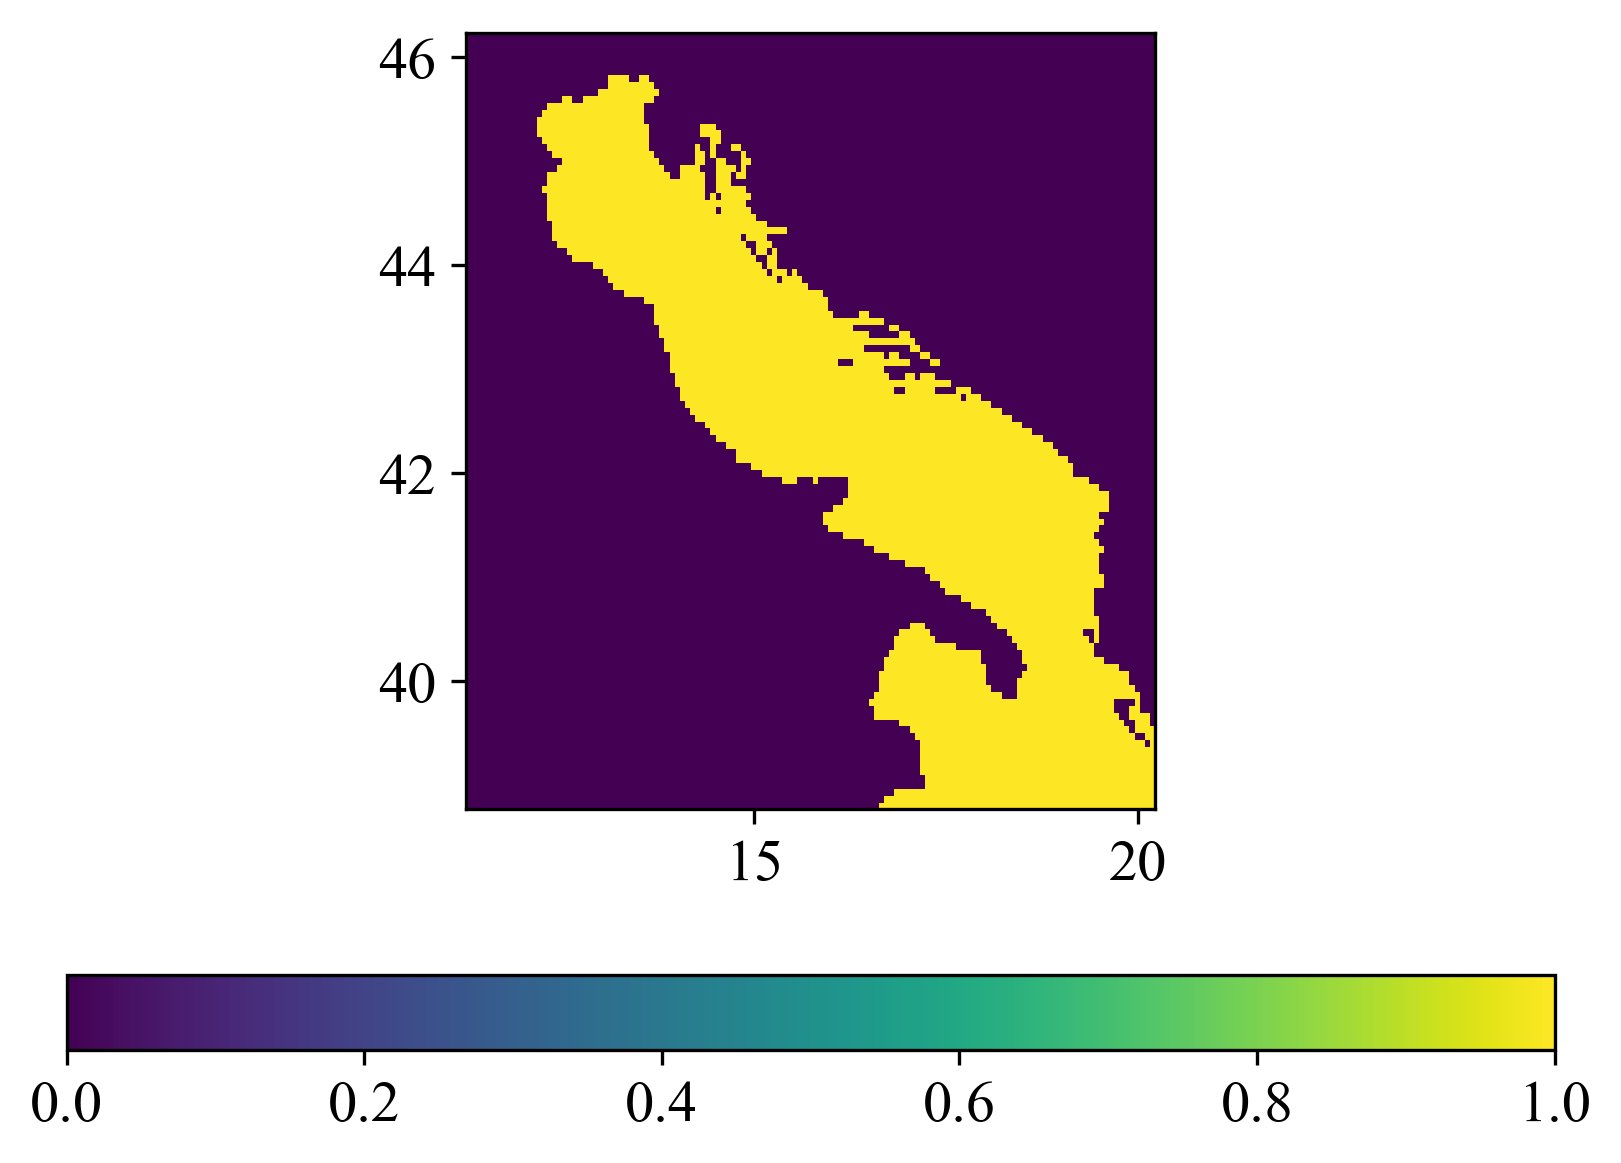

In [58]:
pcolor(bx, by, Float64.(mask_edit[:,:,1])'); 
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

## 3. Extract data from other sources
### 3.1 World Ocean Database

In [29]:
# Configuration
varname = "Salinity"
email = "your-mail@domain"
woddatadir = "./Adriatic/WOD/"
mkpath(woddatadir);

In [ ]:
WorldOceanDatabase.download(lonr,latr,timerange,varname,email,woddatadir);

Read the data

In [135]:
obsvalwod,obslonwod,obslatwod,obsdepthwod,obstimewod,obsidwod = 
WorldOceanDatabase.load(Float64,woddatadir,varname);

Remove the data outside Adriatic (similar to mask editing)

In [134]:
sel_data1 = (obslatwod .<= 42.6) .& (obslonwod .<= 14.);
sel_data2 = (obslatwod .<= 41.2) .& (obslonwod .<= 16.2);
ndataremove = sum((sel_data1) .| (sel_data2))
sel_data = .~((sel_data1) .| (sel_data2));

obslatwod = obslatwod[sel_data];
obslonwod = obslonwod[sel_data];
obsdepthwod = obsdepthwod[sel_data];
obstimewod = obstimewod[sel_data];
obsvalwod = obsvalwod[sel_data];
obsidwod = obsidwod[sel_data];

info("Number of remove WOD data: $ndataremove");

INFO: Number of remove WOD data: 0


Simple plot to check

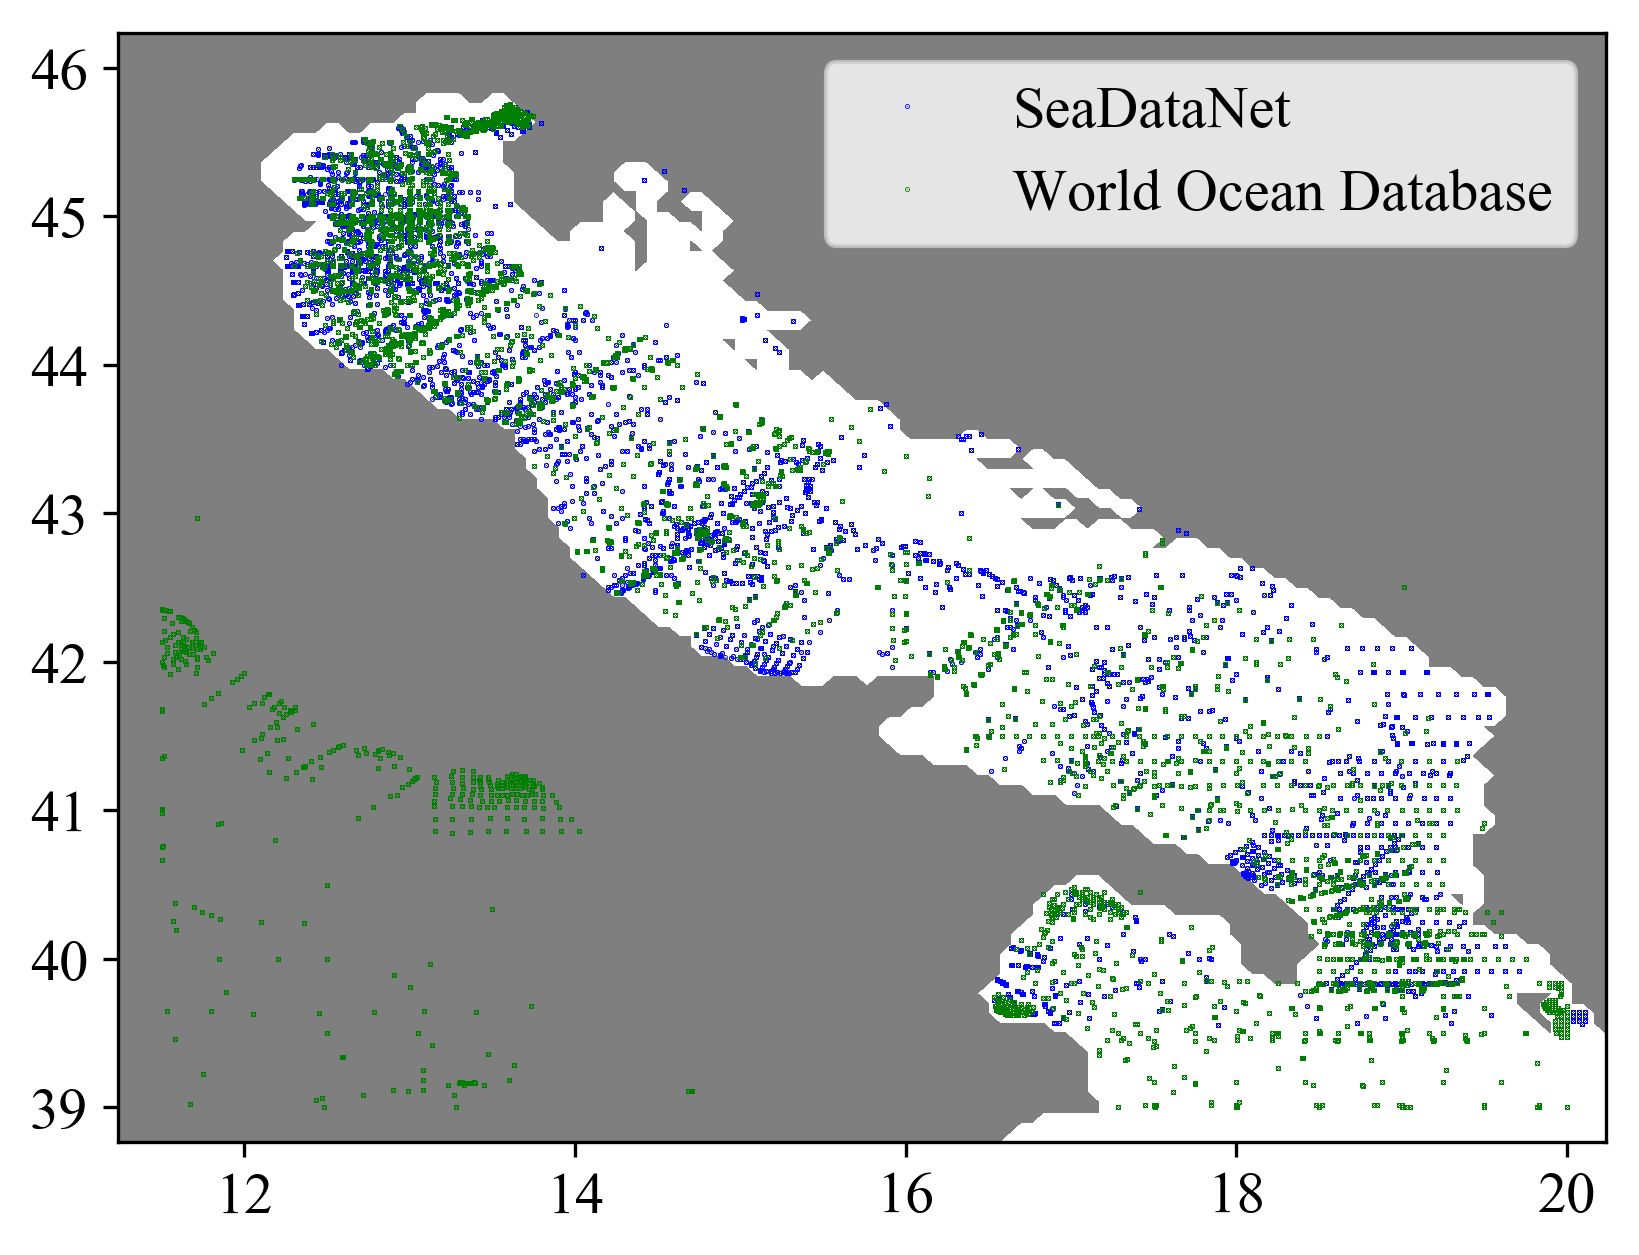

PyObject <matplotlib.legend.Legend object at 0x7faa85725150>

In [69]:
figure()
contourf(bx, by, Float64.(mask_edit[:,:,1])',
    levels=[-1e5,0],cmap="binary"); 
plot(obslon, obslat, "bo", markersize=.2, 
    label="SeaDataNet")
plot(obslonwod, obslatwod, "go", markersize=.2, 
    label="World Ocean Database");
legend();

### 3.2 Extract from another source (optional)


### 3.3 Remove duplicates
Criteria (to adapt):
* Horizontal distance: 0.01 degree (about 1km)
* Vertical separation: 0.01 m depth
* Time separarion: 1 minute.      
* Salinity difference is 0.01 psu.

In [77]:
dupl = divand.Quadtrees.checkduplicates(
    (obslon,obslat,obsdepth,obstime), obsval, 
    (obslonwod,obslatwod, obsdepthwod, obstimewod), obsvalwod,
    (0.01,0.01,0.01,1/(24*60)),0.01);

In [87]:
index = find(.!isempty.(dupl));
ndupl = length(index);
pcdupl = round(ndupl / length(obslon) * 100, 2);
info("Number of possible duplicates: $ndupl")
info("Percentage of duplicates: $pcdupl%")

INFO: Number of possible duplicates: 803047
INFO: Percentage of duplicates: 56.13%


If you decide to combine the 2 (or more) datasets:

In [88]:
newpoints = find(isempty.(dupl));
info("Number of nuew points: " * string(length(newpoints)))
obslon_combined   = [obslon; obslonwod[newpoints]];
obslat_combined   = [obslat; obslatwod[newpoints]];
obsdepth_combined = [obsdepth; obsdepthwod[newpoints]];
obstime_combined  = [obstime; obstimewod[newpoints]];
obsval_combined   = [obsval; obsvalwod[newpoints]];
obsids_combined   = [obsid; obsidwod[newpoints]];

INFO: Number of nuew points: 471356


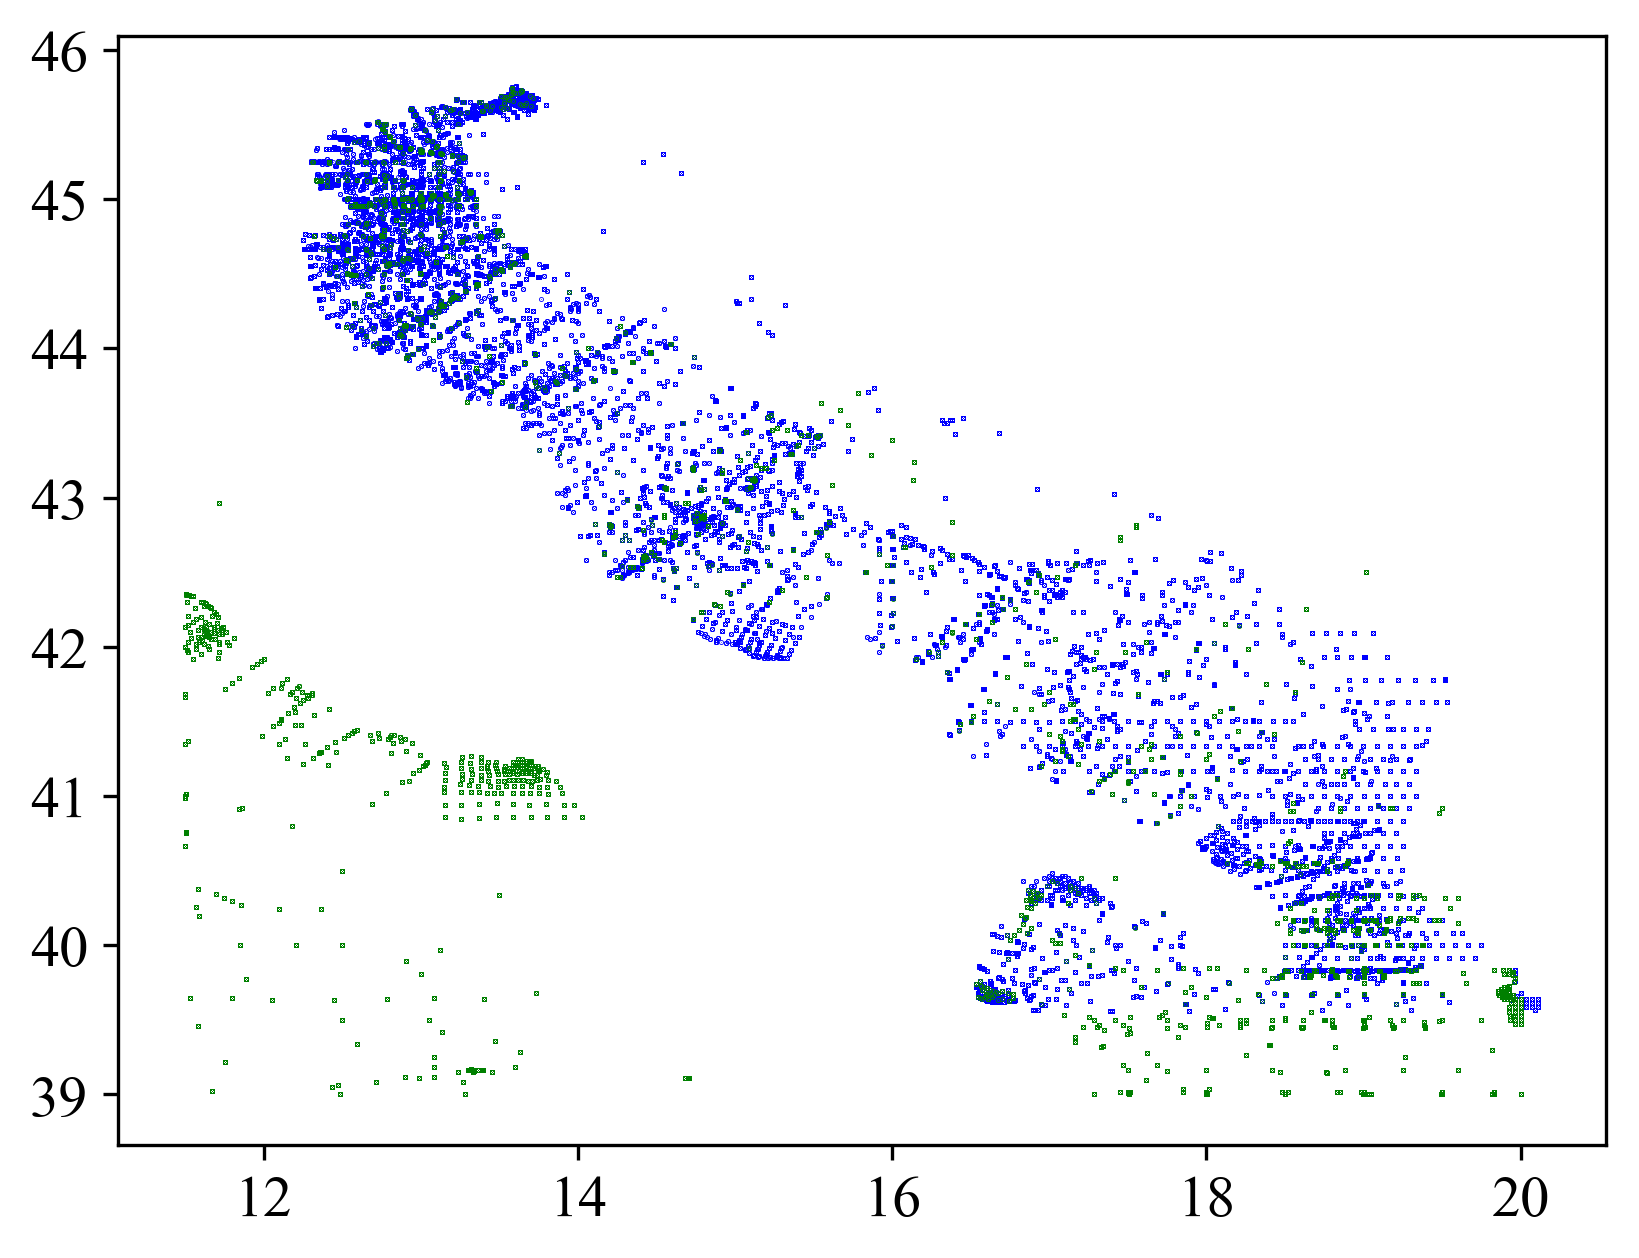

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7faa846487d0>

In [89]:
figure()
plot(obslon, obslat, "bo", markersize=.2, label="SeaDataNet")
plot(obslonwod[newpoints], obslatwod[newpoints], "go", 
    markersize=.2, label="Additional data from World Ocean Database")

## 4. Quality control
We check the salinity value.     
Adapt the criteria to your region and variable.

In [28]:
sel = (obsval .<= 40) .& (obsval .>= 25)

0.9997029511281217

In [ ]:
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsids = obsid[sel];

In [ ]:
years = 1993:1994
year_window = 10

# winter: January-March    1,2,3
# spring: April-June       4,5,6
# summer: July-September   7,8,9
# autumn: October-December 10,11,12

monthlists = [
    [1,2,3],
    [4,5,6],
    [7,8,9],
    [10,11,12]
];

* Other possible choises for the time selector are `TimeSelectorYearListMonthList` and `TimeSelectorRunningAverage`.
* Type `?` followed by these functions

In [23]:
?TimeSelectorYW

search: TimeSelectorYW TimeSelectorYearListMonthList TimeSelectorRunningAverage



```
TS = TimeSelectorYW(years,yearwindow,monthlists)
```

The structure `TS` handles the time aggregation based on `years` and `monthlists`. It is similar to `TimeSelectorYearListMonthList` except that the elements of `yearlists` are centred around `years` and span `yearwindow` years. `yearlists` is in fact constructed by adding and subtracting `yearwindow/2` to every element of years.


In [ ]:
TS = TimeSelectorYW(years,year_window,monthlists)

varname = "Salinity"

# File name based on the variable (but all spaces are replaced by _)
filename = "Water_body_$(replace(varname,' ','_')).4Danl.nc"

# Time origin for the NetCDF file
timeorigin = DateTime(1900,1,1,0,0,0)

A list of all metadata

In [ ]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network",

    # Additional comment
    "comment" => "...",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # http://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "http://dx.doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...")

* Make the NetCDF global and variable attributes based on the metadata.
* Custom attributes can be added by changing `ncglobalattrib`:

```julia
ncglobalattrib["attribute_name"] = "attribute_value"
```


In [ ]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

Plot the results the surface for debugging and quick inspection.

To generate the plots, we define a function `plotres` (see next cell) that will be used as an optional argument when we call the interpolation with `DIVAnd`.

In [ ]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    tmp[erri .> .5] = NaN;
    figure(figsize = (10,8))
    subplot(2,1,1)
    title("$(timeindex)")
    
    # select the data near the surface
    selsurface = sel .& (obsdepth .< 5)
    vmin = minimum(obsval[selsurface])
    vmax = maximum(obsval[selsurface])
    
    # plot the data
    scatter(obslon[selsurface],obslat[selsurface],10,obsval[selsurface];
            vmin = vmin, vmax = vmax)
    xlim(minimum(lonr),maximum(lonr))
    ylim(minimum(latr),maximum(latr))
    colorbar()
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
    
    # plot the analysis
    subplot(2,1,2)
    pcolor(lonr,latr,tmp[:,:,1]';
           vmin = vmin, vmax = vmax)
    colorbar()
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
end

If you do not want to generate plots but print the time index at every time slice
you can use the function `plotres_timeindex`.

In [ ]:
function plotres_timeindex(timeindex,sel,fit,erri)
@show timeindex
end

Launch the analysis. Plotting can be disabled by commenting the line containing `plotres`.

Here we use `diva3d`, which performs a series of 3D analyses (lon, lat and depth) for the different periods defined previously.

In [ ]:
?diva3d

In [ ]:
if isfile(filename)
   rm(filename) # delete the previous analysis
end

@time dbinfo = diva3d((lonr,latr,depthr,TS),
              (obslon,obslat,obsdepth,obstime),
              obsval,
              (lenx,leny,lenz),
              epsilon2,
              filename,varname,
              bathname = bathname,
              bathisglobal = bathisglobal,
              plotres = plotres,
              ncvarattrib = ncvarattrib,
              ncglobalattrib = ncglobalattrib,
              timeorigin = timeorigin
       );


residual = dbinfo[:residuals];

This generates many plots (one for every time instance).     
The number in the title is the time index starting with the first season and year.


Save the observation metadata in the NetCDF file

In [ ]:
divand.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid)

In [ ]:
dbinfo

## XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project ("SeaDataCloud" or "EMODNET-chemistry")

In [ ]:
project = "SeaDataCloud";

Download CDI list

In [ ]:
cdilist = "CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [ ]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by _)
xmlfilename = "Water_body_$(replace(varname,' ','_')).4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [ ]:
# generate a XML file for Sextant (only for )
#divadoxml(filename,varname,project,cdilist,xmlfilename,
#          ignore_errors = ignore_errors)